In [1]:
import sys
sys.path.append('../src/')

from tenzing.core.model_implementations.sub_types import missing, infinite
from tenzing.core.model_implementations import *
from tenzing.core.model_implementations.typesets import *
from tenzing.core.model_implementations import sub_types
from tenzing.core.model_implementations.typesets import tenzing_complete_set, tenzing_standard
import datetime
import numpy as np
import networkx as nx

import pandas as pd
%matplotlib inline

In [2]:

df = pd.DataFrame(
    {
        "item_id": [1, 1, 3],
        "item_cost": [2.1, 3.5, 4],
        "item_name": ["orange", "orange", "apple"],
        "sale_date": pd.to_datetime(
            [
                datetime.date(2011, 1, 1),
                datetime.date(2012, 1, 2),
                datetime.date(2013, 1, 1),
            ]
        ),
        "store_location": pd.Series(
            ["POINT (12 42)", "POINT (100 42.723)", "POINT (0 0)"]
        ),
        "COGS": pd.Series([np.nan, 1.1, 2.1]).astype(str),
        "is_still_available": [True, False, True],
        "is_expired": ["True", "false", "False"],
        "is_person": ["Y", "N", "Y"],
        "website": [
            "http://www.google.com",
            "http://www.bing.com",
            "http://www.duckduckgo.com",
        ],
        "complex_record": [np.complex(1, 2), np.complex(3, 4), np.complex(5, 6)],
        "path_linux": [
            r"/home/user/test.txt",
            r"/home/user/test.bat",
            r"/home/user/test.sh",
        ],
        "path_win": [r"C:\Users\test.txt", r"C:\Users\test.bat", r"C:\Users\test.sh"],
    }
)

ts = tenzing_complete_set()
ts.prep(df)
inferred_types = ts.infer_types(df)
inferred_types


df_clean = ts.cast_to_inferred_types(df)

print("inferred types after convert")
inferred_types_cast = ts.infer_types(df_clean)


inferred types after convert


In [3]:
int_string_nan_series = pd.Series(["1.0", "2.0", np.nan])
series = int_string_nan_series

In [4]:
from functools import partial
from tenzing.core.models import model_relation
self = tenzing_integer + missing


def wrap_subtype_method(self, method_name):
    def wrap(outer, inner):
        return lambda x: outer(inner(x))
    wrapped_func = getattr(self, method_name)
    for typex in self.types:
        wrapped_func = wrap(wrapped_func, getattr(typex, method_name))
    return wrapped_func

def masked_relation(self, relation):
    def relationship(series):
        return relation.relationship(series[~self.get_mask(series)])

    def transformer(series):
        mask = ~self.get_mask(series)
        transformed_series = series.copy()
        transformed_series[mask] = relation.transformer(series[mask])
        return transformed_series
        
    return model_relation(self, relation.friend_model, relationship, transformer)
        
def _construct_relations(self):
    self._relations = {}
    for related_type, relation in self.base_type.get_relations().items():
        self._relations[related_type] = masked_relation(self, relation)
    

In [5]:
from tenzing.core.typesets import infer_type, traverse_relation_graph
standard_typeset = tenzing_standard()



(tenzing_float, tenzing_generic, tenzing_model, object)

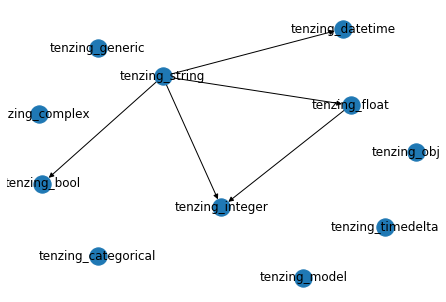

In [10]:
int_string_nan_series = pd.Series(["1.0", "2.0", np.nan])
series = int_string_nan_series
series_type = traverse_relation_graph(series, standard_typeset.inheritance_graph)
inferred_type = infer_type(series_type, series, standard_typeset.relation_graph)

nx.draw_kamada_kawai(standard_typeset.relation_graph, with_labels=True)
standard_typeset.get_mro(list(standard_typeset.types)[0])


In [ ]:
mask = np.zeros_like(series, dtype=bool)
for type in self.types:
    mask |= type.get_mask(series)
rest_mask = ~mask
subs = all(series[type.get_mask(series)] in type for type in self.types)
rest = series[rest_mask] in self.base_type

In [3]:
ts = tenzing_standard()
ts.prep(df)

ts.infer_types(df)


NameError: name 'df' is not defined

In [42]:
@singleton.singleton_object
class tenzing_float(uniqueSummaryMixin, tenzing_model):
    """**Float** implementation of :class:`tenzing.core.models.tenzing_model`.

    >>> x = pd.Series([1.0, 2.5, 5.0, np.nan])
    >>> x in tenzing_float
    True
    """
    def contains_op(self, series):
        if not pdt.is_float_dtype(series):
            return False
        # TODO: are we sure we want this to depend on integer?
        elif series in tenzing_integer:
            return False
        else:
            return True

    def cast_op(self, series):
        return series.astype(float)

    def summarization_op(self, series):
        aggregates = ['nunique', 'mean', 'std', 'var', 'max', 'min', 'median', 'kurt', 'skew', 'sum', 'mad']
        summary = series.agg(aggregates).to_dict()

        quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
        for percentile, value in series.quantile(quantiles).to_dict().items():
            summary["quantile_{:d}".format(int(percentile * 100))] = value

        summary["range"] = summary["max"] - summary["min"]
        summary["iqr"] = summary["quantile_75"] - summary["quantile_25"]
        summary["cv"] = summary["std"] / summary["mean"] if summary["mean"] else np.NaN

        # TODO: move to common
        summary['n_records'] = series.shape[0]
        summary['memory_size'] = series.memory_usage(index=True, deep=True),


        # TODO: only calculations for histogram, not the plotting
        # summary['image'] = plotting.histogram(series)
        return summary

series = pd.Series([1.0, 2.0, np.nan, 1.0])
tenzing_float.summarize(series)


NameError: name 'singleton' is not defined

In [4]:
uniqueSummaryMixin().summarization_op(series)

{'n_unique': 2, 'p_unique': 1.0}

In [2]:
def contains_op(series):
    if pdt.is_integer_dtype(series):
        return True
    elif pdt.is_float_dtype(series):
        # Need this additional check because it's an Option[Int] which in
        # pandas land will result in integers with decimal trailing 0's
        return series.eq(series.astype(int)).all()
    else:
        return False
    
contains_op(series)

NameError: name 'series' is not defined

In [ ]:
# This is causing errors because ALL numeric strings can be cast to floats
# The relationship needs to exclude integers.
model = tenzing_float
relation = tenzing_string
series = pd.Series(range(10))

relation = model.relations[relation]
operation = None
self = relation.model
operation = operation if operation is not None else self.cast_op

result = 'Not a relation'
if relation.is_relation(series):
    idx = series.isna()
    if idx.any():
        result = series.copy()
        result[~idx] = operation(series[~idx])
    else:
        result = operation(series)
result in model


In [ ]:
series = pd.Series(range(20))
relation.is_relation(series)

In [ ]:
def get_series(series):
    if series.hasnans:
        ret = series[series.notna()]
    else:
        ret = series
    return ret
 
def get_series2(series):
    return series[series.notna()]


series = pd.Series([i for i in range(100000)] + [np.nan])
%timeit get_series(series)
%timeit get_series2(series)

In [ ]:
series = pd.Series(['1', '2'])
operation = None
operation = operation if operation is not None else tenzing_integer.cast_op
idx = series.notna()
result = series.copy()
result[idx] = operation(series[idx]).infer_objects()
result

In [ ]:
s = pd.Series(range(10000000), dtype='object')
%timeit s.infer_objects()

In [ ]:
%timeit pd.Series(s.tolist())

In [ ]:
def string_is_geometry(series):
    """
        Shapely logs failures at a silly severity, just trying to suppress it's output on failures.
    """
    import logging
    from shapely import wkt
    logging.disable()
    try:
        result = all(wkt.loads(value) for value in series)
    except Exception:
        result = False
    finally:
        logging.disable(logging.NOTSET)

    return result

series = pd.Series(['a', 'b'])
string_is_geometry(series)

In [ ]:
def evaluate_transform_path():
    pass
source_type = tenzing_string
target_type = tenzing_integer
#def get_type_inference_path(series, source_type, target_type, G):
paths = nx.all_shortest_paths(G, source=source_type, target=target_type)

def get_type_inference_path(base_type, series, G, path=[]):
    path.append(base_type)
    for tenz_type in G.successors(base_type):
        if G[base_type][tenz_type]['relationship'].is_relation(series):
            new_series = G[base_type][tenz_type]['relationship'].transform(series)
            return get_type_inference_path(tenz_type, new_series, G, path)
    return path


get_type_inference_path(source_type, series, G)
        


In [ ]:
nx.draw_kamada_kawai(G, with_labels=True)

In [ ]:
from tenzing.core.model_implementations.typesets import tenzing_standard

df = pd.DataFrame({'Col 1': range(3), 
                   'Col 2': [2 * i for i in range(3)], 
                   'Col 3': ['howdy', 'howdy', 'doody'],
                   'times': pd.to_datetime([datetime.date(2011,1,1), datetime.date(2012, 1, 1), datetime.date(2013,1,1)])})
x = tenzing_standard()
x.prep(df)
summer = x.summarize(df)


In [ ]:
x = tenzing_standard()
x.prep(df)
y = x.summary_report(df)
y

In [ ]:

from pandas_profiling import ProfileReport
ProfileReport(df)


In [ ]:
types = tenzing_standard().types
series = df['Col 3']
[tenzing_type for tenzing_type in types if series in tenzing_type]

In [ ]:
x.relation_map

In [ ]:
from tenzing.core.models import tenzing_model

type(tenzing_model)

In [ ]:
tenzing_integer

In [ ]:
import pandas as pd
import numpy as np
x = pd.Series([1,2,3, np.nan])

print(x in tenzing_integer)
print(x in tenzing_float)

In [ ]:
int_float_relation = model_relation(tenzing_float, lambda x: False, lambda x: False)
tenzing_float.register_relation(int_float_relation)

In [ ]:
import numpy as np

x = pd.Series(list(range(10000)))
%timeit x.astype(np.float)
%timeit x.astype(float)

In [ ]:
x.astype(int).nbytes

In [ ]:
test_series = pd.Series([pd.datetime(2010, 1, 1), pd.datetime(2010, 8, 2), pd.datetime(2011, 2, 1), np.nan])
tenzing_timestamp.summarize(test_series)

In [ ]:
root_types = [tenzing_bool, tenzing_float, tenzing_object,
                      tenzing_complex, tenzing_categorical, tenzing_timestamp,
                      tenzing_integer]

In [ ]:
[node.edge for s_node in root_types for to, node in s_node.relations.items()]

In [ ]:
root_types[-1].relations.items()

In [ ]:
root_types

In [ ]:
pd.Series(['1.0', '2.0']).astype(float)

In [ ]:
series = pd.Series([1.0, 2.0, np.nan]).astype('str')
#series = pd.Series(range(20)).astype('str')

In [ ]:
from tenzing.core.typesets import infer_type, traverse_relation_graph, build_relation_graph
from tenzing.core.model_implementations.typesets import tenzing_standard

G = tenzing_standard().relation_map

In [ ]:
series_type = traverse_relation_graph(series, G)
inferred_type = infer_type(series_type, series, G)

In [ ]:
series_type

In [ ]:
inferred_type

In [ ]:
def infer_type(base_type, series, G):
    print(series.dtype)
    for tenz_type in G.successors(base_type):
        relation = G[base_type][tenz_type]['relationship']
        if relation.is_relation(series):
            new_series = relation.transform(series)
            return infer_type(tenz_type, new_series, G)
    return base_type
infer_type(tenzing_string, series, G)

In [ ]:
G[tenzing_float][tenzing_string]['relationship'].transformer

In [ ]:
relation = G[tenzing_string][tenzing_float]['relationship']

ns = relation.friend_model.get_series(series)
relation.transform(ns)

In [ ]:
from tenzing.utils import singleton, test_utils
class model_relation:
    """
    Hub and spoke model - these are relationships of the form
    friend_model -> model of model_relation

    """
    def __init__(self, model, friend_model, relationship=None, transformer=None):
        self.model = model
        self.friend_model = friend_model
        self.edge = (self.friend_model, self.model)
        self.relationship = relationship if relationship else self.model.__contains__
        self.transformer = transformer if transformer else self.model.cast

    def is_relation(self, obj):
        return self.relationship(self.friend_model.get_series(obj))

    def transform(self, obj):
        return self.transformer(self.friend_model.get_series(obj))

r = model_relation(tenzing_string, tenzing_object)
ns = r.friend_model.get_series(series)
ns.astype(str)

In [ ]:
series.astype('object')

In [ ]:
nx.draw_kamada_kawai(G, with_labels=True)

In [ ]:
G[tenzing_object]